In [1]:
%matplotlib inline
import numpy as np
import os
import h5py
from matplotlib import pyplot as plt
from pandas import DataFrame
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
from astropy import units as u
from tqdm import tqdm as progress_bar
import matplotlib.lines as mlines

from fancy import Data, Model, Analysis
from fancy.interfaces.stan import get_simulation_input, convert_scale, coord_to_uv, uv_to_coord
# from fancy.plotting import AllSkyMap
from fancy.plotting import AllSkyMapCartopy as AllSkyMap
from fancy.propagation.energy_loss import get_Eth_src, get_kappa_ex, get_Eex, get_Eth_sim, get_arrival_energy, get_arrival_energy_vec
from fancy.detector.vMF.vmf import sample_vMF, sample_sphere
from fancy.detector.exposure import m_dec
from multiprocessing import Pool, cpu_count
from scipy.stats import bernoulli

import sys

sys.path.append("/opt/CRPropa3/lib/python3.8/site-packages")
import crpropa


'''Setting up'''

# Define location of Stan files
stan_path = '../../stan/'

# Define file containing source catalogue information
source_file = '../../data/sourcedata.h5'

# make output directory if it doesnt exist
if not os.path.isdir("output"):
    os.mkdir("output")

# source_types = ["SBG_23", "2FHL_250Mpc", "swift_BAT_213"]
source_types = ["SBG_23"]

# detector_types = ["auger2010", "auger2014", "TA2015"]
# detector_type = "auger2014"
detector_type = "TA2015"

# set random seed
random_seeds = [19990308]
# random_seeds = [19990308, 4968460, 165490, 87, 7984165, 168490, 9874651, 980, 546, 7984, 333, 2]
# random_seed = 165490849

# flag to control showing plots or not
show_plot = True

ptype = "p"

tightB_label = "None"

'''set detector and detector properties'''
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, alpha_T, M, Eth
else:
    raise Exception("Undefined detector type!")


In [2]:
# Define a Stan simulation to run
sim_name = stan_path + 'joint_gmf_model_sim.stan' # simulate all processes
# sim_name = stan_path + 'joint_model_sim.stan' # simulate all processes
# Define simulation using Model object and compile Stan code if necessary
simulation = Model(sim_filename = sim_name, include_paths = stan_path)
simulation.compile(reset=False)

# define separate files
table_file = '../../../tables/tables_{0}_{1}.h5'.format(source_types[0], detector_type)
sim_output_file = 'output/joint_gmf_model_simulation_{0}_{1}_{2}_{3}_{4}.h5'.format(source_types[0], detector_type, random_seeds[0], ptype, tightB_label)

# Define a source catalogue and detector exposure
# In the paper we use the SBG catalogue
data = Data()
data.add_source(source_file, source_types[0])
data.add_detector(detector_properties)

# Plot the sources in Galactic coordinates
# if show_plot:
#     data.show();

# Define associated fraction
f = 0.5 

# Simulation input
B = 20 # nG
alpha = 3.0
Eth = Eth   
Eth_sim = 20 # EeV
ptype = ptype  # assume proton

# number of simulated inputs
# changes the background flux linearly
# should choose Nsim such that FT is the same for
# each observatory
# this ensures that L, F0 are the same
# 
# for PAO, we saw that FT, detector_type = 0.3601
FT_PAO = 0.3601   # total, detector_type flux using {1} data with Nsim = 2500, detector_type
Nsim_expected = FT_PAO / (M / alpha_T)
Nsim = int(np.round(Nsim_expected))

# check value for Nsim
print("Simulated events: {0}".format(Nsim))


# L in yr^-1, F in km^-2 yr^-1
L, F0 = get_simulation_input(Nsim, f, data.source.distance, M, alpha_T)

# To scale between definition of flux in simulations and fits
flux_scale = (Eth / Eth_sim)**(1 - alpha)

simulation.input(B = B, L = L, F0 = F0,
            alpha = alpha, Eth = Eth, ptype=ptype)

# check luminosity and isotropic flux values
# L ~ O(10^39), F0 ~ 0.18
# same luminosity so only need to check one value
print("Simulated Luminosity: {0:.3e}".format(L[0]))
print("Simulated isotropic flux: {0:.3f}".format(F0))


# What is happening 
summary = b'Simulation using the joint model and SBG catalogue' # must be a byte str
    
# Define an Analysis object to bring together Data and Model objects
# sim_analysis = Analysis(data, simulation, analysis_type = 'joint_gmf', 
#                     filename = sim_output_file, summary = summary)

sim_analysis = Analysis(data, simulation, analysis_type = 'joint_gmf', 
                    filename = sim_output_file, summary = summary)

print("Building tables...")

# Build pre-computed values for the simulation as you go
# So that you can try out different parameters
sim_analysis.build_tables(sim_only = True)

eps = sim_analysis.tables.sim_table

# handle selected sources
if (sim_analysis.data.source.N < len(eps)):
    eps = [eps[i] for i in sim_analysis.data.source.selection]

# convert scale for sampling
D = sim_analysis.data.source.distance
alpha_T = sim_analysis.data.detector.alpha_T
L = sim_analysis.model.L
F0 = sim_analysis.model.F0
D, alpha_T, eps, F0, L = convert_scale(D, alpha_T, eps, F0, L)

if sim_analysis.analysis_type == sim_analysis.joint_type \
    or sim_analysis.analysis_type == sim_analysis.E_loss_type \
        or sim_analysis.analysis_type == sim_analysis.gmf_type:
    # find lower energy threshold for the simulation, given Eth and Eerr
    if Eth_sim:
        sim_analysis.model.Eth_sim = Eth_sim

# compile inputs from Model and Data
sim_analysis.simulation_input = {
    'kappa_d': sim_analysis.data.detector.kappa_d,
    'Ns': len(sim_analysis.data.source.distance),
    'varpi': sim_analysis.data.source.unit_vector,
    'D': D,
    'A': sim_analysis.data.detector.area,
    'a0': sim_analysis.data.detector.location.lat.rad,
    'lon': sim_analysis.data.detector.location.lon.rad,
    'theta_m': sim_analysis.data.detector.threshold_zenith_angle.rad,
    'alpha_T': alpha_T,
    'eps': eps
}

sim_analysis.simulation_input['L'] = L
sim_analysis.simulation_input['F0'] = F0
sim_analysis.simulation_input['distance'] = sim_analysis.data.source.distance

if sim_analysis.analysis_type == sim_analysis.arr_dir_type or sim_analysis.analysis_type == sim_analysis.E_loss_type:

    sim_analysis.simulation_input['kappa'] = sim_analysis.model.kappa

if sim_analysis.analysis_type == sim_analysis.E_loss_type:

    sim_analysis.simulation_input['alpha'] = sim_analysis.model.alpha
    sim_analysis.simulation_input['Eth'] = sim_analysis.model.Eth_sim
    sim_analysis.simulation_input[
        'Eerr'] = sim_analysis.data.detector.energy_uncertainty

if sim_analysis.analysis_type == sim_analysis.joint_type:

    sim_analysis.simulation_input['B'] = sim_analysis.model.B
    sim_analysis.simulation_input['alpha'] = sim_analysis.model.alpha
    sim_analysis.simulation_input['Eth'] = sim_analysis.model.Eth_sim
    sim_analysis.simulation_input[
        'Eerr'] = sim_analysis.data.detector.energy_uncertainty

if sim_analysis.analysis_type == sim_analysis.gmf_type:

    sim_analysis.simulation_input['B'] = sim_analysis.model.B
    sim_analysis.simulation_input['alpha'] = sim_analysis.model.alpha
    sim_analysis.simulation_input['Eth'] = sim_analysis.model.Eth_sim
    sim_analysis.simulation_input[
        'Eerr'] = sim_analysis.data.detector.energy_uncertainty

    # get particle type we intialize simulation with
    sim_analysis.ptype = sim_analysis.model.ptype
    _, Z = sim_analysis.nuc_table[sim_analysis.ptype]
    sim_analysis.simulation_input["Z"] = Z

try:
    if sim_analysis.data.source.flux:
        sim_analysis.simulation_input['flux'] = sim_analysis.data.source.flux
    else:
        sim_analysis.simulation_input['flux'] = np.zeros(sim_analysis.data.source.N)
except:
    sim_analysis.simulation_input['flux'] = np.zeros(sim_analysis.data.source.N)

# run simulation
print('Running Stan simulation...')
sim_analysis.simulation = sim_analysis.model.simulation.sampling(
    data=sim_analysis.simulation_input,
    iter=1,
    chains=1,
    algorithm="Fixed_param",
    seed=random_seeds[0])

# extract output
print('Extracting output...')

sim_analysis.Nex_sim = sim_analysis.simulation.extract(['Nex_sim'])['Nex_sim']
# source_labels: to which source label each UHECR is associated with
sim_analysis.source_labels = (
    sim_analysis.simulation.extract(['lambda'])['lambda'][0] - 1).astype(int)

sim_analysis.Earr = sim_analysis.simulation.extract(
    ['Earr'])['Earr'][0]  # arrival energy
sim_analysis.E = sim_analysis.simulation.extract(
    ['E'])['E'][0]  # sampled from spectrum

kappas = sim_analysis.simulation.extract(['kappa'])['kappa'][0]

N_uhecr = len(kappas)

Using cached StanModel
Simulated events: 451
Simulated Luminosity: 3.351e+39
Simulated isotropic flux: 0.180
Building tables...


Precomputing exposure integral: 100%|██████████| 23/23 [00:02<00:00, 10.71it/s]



Running Stan simulation...
Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.261165 seconds (Sampling)
               0.261165 seconds (Total)

Extracting output...


In [3]:
source_labels = sim_analysis.source_labels
varpi = sim_analysis.data.source.unit_vector

Nrand = 100

# get source vector in which uhecr is associated with
# otherwise the UHECR is associated with background
varpi_per_uhecr = []
for lmbda in source_labels:
    if lmbda == len(varpi):  # if background
        varpi_per_uhecr.append(None)
    else:
        varpi_per_uhecr.append(np.array(varpi[lmbda]))

# get UHECR indices correlating to background and source
src_indices = np.argwhere(source_labels != len(varpi))
bg_indices = np.argwhere(source_labels == len(varpi))

# obtain arrival directions at the galactic boundary
omega_gb = []
for i, lmbda in enumerate(source_labels):
    if lmbda == len(
            varpi):  # from background, sample from sphere uniformly
        omega_gb_bg = sample_sphere(1, Nrand)
        omega_gb.append(omega_gb_bg)
    else:  # from source, sample from vmf
        omega_gb_src = sample_vMF(varpi_per_uhecr[i], kappas[i], Nrand)
        omega_gb.append(omega_gb_src)

coords_gb = uv_to_coord(omega_gb) # [uv_to_coord(omega_gb_i) for omega_gb_i in omega_gb]


coords_src = sim_analysis.data.source.coord


<Figure size 504x360 with 0 Axes>

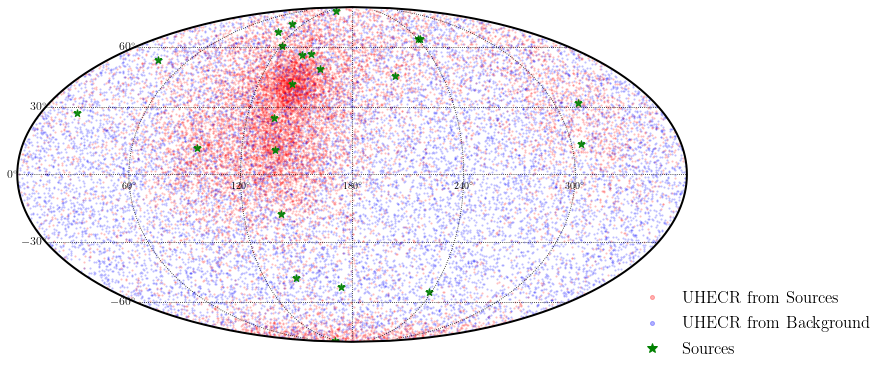

In [4]:
plt.style.use("minimalist")

lons_gb, lats_gb = 180 - coords_gb.galactic.l.deg, coords_gb.galactic.b.deg
lons_src, lats_src = 180 - coords_src.galactic.l.deg, coords_src.galactic.b.deg

skymap = AllSkyMap(lon_0 = 180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
skymap.scatter(lons_gb[:100, src_indices], lats_gb[:100, src_indices], s=4.5, color="r", alpha=0.25, label="UHECR from Sources", lw=0)
skymap.scatter(lons_gb[:100, bg_indices], lats_gb[:100, bg_indices], s=4.5, color="b", alpha=0.25, label="UHECR from Background", lw=0)
skymap.scatter(lons_src, lats_src, s=60.0, color="g", alpha=0.9, marker="*", label="Sources")


handles = [mlines.Line2D([], [], color='r', marker='o', lw=0,
                          markersize=4, alpha=0.3, label="UHECR from Sources"),
           mlines.Line2D([], [], color='b', marker='o', lw=0,
                          markersize=4, alpha=0.3, label="UHECR from Background"),
            mlines.Line2D([], [], color='g', marker='*', lw=0,
                          markersize=10, label="Sources")]

skymap.legend(handles=handles, bbox_to_anchor=(0.9, 0.2)) 
# skymap.title("Skymap of vMF distributed UHECRs from Sources and Background")
# skymap.save("test2.png",bbox_inches="tight", dpi=300)
skymap.save("GMFplots_vMF_skymap_{0}_{1}.png".format(ptype, tightB_label), dpi=400)


In [5]:
path_to_lens = os.path.join("JF12full_Gamale",
            "lens.cfg")

energies_gb = sim_analysis.Earr * crpropa.EeV  # UHECR energy at gal. boundary
A, Z = sim_analysis.nuc_table[sim_analysis.ptype]
pid = crpropa.nucleusId(A, Z)

In [6]:
'''For map that combines src + bg'''
MC = crpropa.ParticleMapsContainer()

# divide energy by Z to get rigidity (to account for composition)
rigidities_gb = np.array(
    [np.float64(energy_gb) / Z for energy_gb in energies_gb])

# add particle to map container
# Coordinate transformation is based on making the final map used for sampling
# to be sampled in the correct coordinates.
for i in range(N_uhecr):
    i = int(i)
    for j in range(Nrand):
        c_gal = coords_gb[j][i].galactic
        MC.addParticle(pid, rigidities_gb[i],
                                    -(np.pi - c_gal.l.rad), c_gal.b.rad)

In [7]:
# evaluate map used to plot unlensed map using healpy
NPIX = MC.getNumberOfPixels(
)  # hardset to 49152 via CRPropa, correleats to ang. res of 0.92 deg
crMap_unlensed = np.zeros(NPIX)
rigidities = MC.getEnergies(
    int(pid))  # actually getting rigidity
for rigidity in rigidities:
    crMap_unlensed += MC.getMap(int(pid),
                                            rigidity * crpropa.eV)


<Figure size 504x360 with 0 Axes>

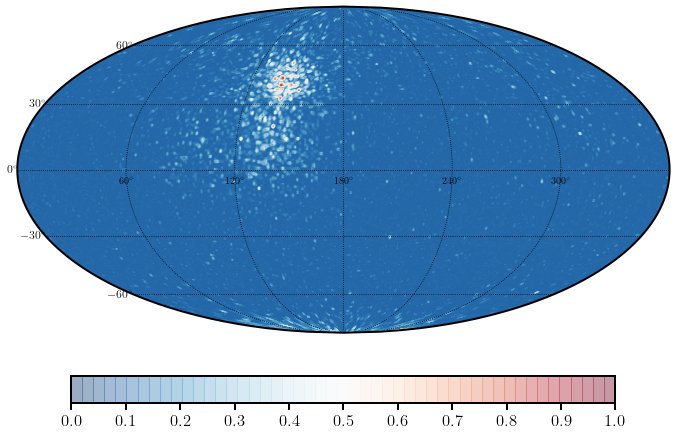

In [8]:

import healpy
import matplotlib.cm as cm


# healpy.mollview(map=crMap_unlensed, title='UHECR Map at Galactic Boundary', rot=(90, 0, 0), cmap=cm.hot)
ipixs = np.arange(0, 49152, 1, dtype=int)
th, ph = healpy.pix2ang(healpy.npix2nside(49152), ipixs)
lons_crmap, lats_crmap = -np.rad2deg(np.pi - ph), np.rad2deg(np.pi / 2. - th)


# UHECR at earth after lensing

max_count = int(np.max(crMap_unlensed))
from scipy.interpolate import griddata
import cartopy.crs as ccrs
# import matplotlib.cm as cm

grid_lons, grid_lats = np.mgrid[-200:200:300j, -90:90:300j]

grid_crMap_unlensed = griddata((lons_crmap, lats_crmap), crMap_unlensed / max_count, (grid_lons, grid_lats), method="cubic", fill_value=0)

# energy_bins = np.arange(0, int(np.max(map_unlensed))+1, 1)
# uhecr_norm = mcolors.BoundaryNorm(energy_bins, cm.hot_r.N)


skymap = AllSkyMap(figsize=(15,8), lon_0=180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
im = skymap.ax.contourf(grid_lons, grid_lats, grid_crMap_unlensed, transform=ccrs.PlateCarree(), cmap=cm.RdBu_r, levels=np.linspace(0, 1, 50), alpha=0.4)
skymap.ax.set_facecolor('w')
# skymap.title("UHECR Map at Galactic Boundary")
cbar = skymap.fig.colorbar(im,  pad=0.1,
                                cmap=im.cmap,
                                orientation='horizontal',
                                alpha=1, shrink=0.65)

# cbar.ax.set_xlim(0, int(np.max(map_unlensed))+1)
# cbar.ax.set_xticks(np.arange(0, int(np.max(map_unlensed))+1, 1))
cbar.set_ticks(np.arange(0, 1.1, 0.1))
cbar.set_ticklabels(["{0:.1f}".format(i) for i in np.arange(0, 1.1, 0.1)])

skymap.save("GMFplots_unlensed_skymap_{0}_{1}.png".format(ptype, tightB_label), dpi=400)

In [9]:
# apply lens of b-field model to get map of uhecrs at earth
# full lens to account for turbulent effects
lens = crpropa.MagneticLens(path_to_lens)
lens.normalizeLens()
MC.applyLens(lens)

# same as above, but for lensed version
crMap_lensed = np.zeros(NPIX)
rigidities = MC.getEnergies(int(pid))
for rigidity in rigidities:
    crMap_lensed += MC.getMap(int(pid),
                                            rigidity * crpropa.eV)

RuntimeError: Can't read file: JF12full_Gamale/lens.cfg

<Figure size 504x360 with 0 Axes>

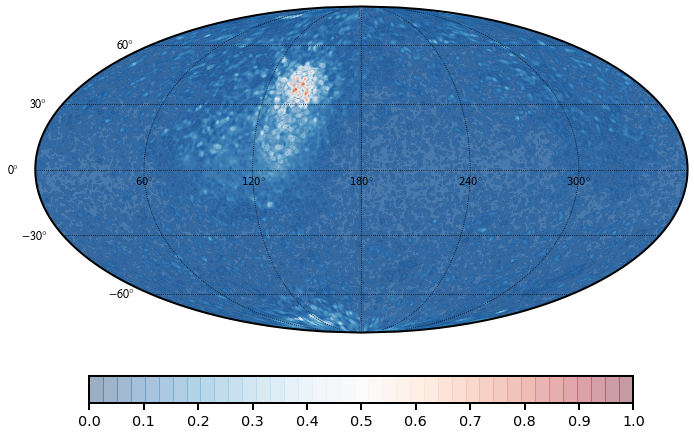

In [ ]:

import healpy
import matplotlib.cm as cm


# healpy.mollview(map=crMap_lensed, title='UHECR Map at Galactic Boundary', rot=(90, 0, 0), cmap=cm.hot)
ipixs = np.arange(0, 49152, 1, dtype=int)
th, ph = healpy.pix2ang(healpy.npix2nside(49152), ipixs)
lons_crmap, lats_crmap = -np.rad2deg(np.pi - ph), np.rad2deg(np.pi / 2. - th)


# UHECR at earth after lensing

max_count = np.max(crMap_lensed)
from scipy.interpolate import griddata
import cartopy.crs as ccrs
# import matplotlib.cm as cm

grid_lons, grid_lats = np.mgrid[-200:200:300j, -90:90:300j]

grid_crMap_lensed = griddata((lons_crmap, lats_crmap), crMap_lensed / max_count, (grid_lons, grid_lats), method="cubic", fill_value=0)

# energy_bins = np.arange(0, int(np.max(map_unlensed))+1, 1)
# uhecr_norm = mcolors.BoundaryNorm(energy_bins, cm.hot_r.N)


skymap = AllSkyMap(figsize=(15,8), lon_0=180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
im = skymap.ax.contourf(grid_lons, grid_lats, grid_crMap_lensed, transform=ccrs.PlateCarree(), cmap=cm.RdBu_r, levels=np.linspace(0, 1, 40), alpha=0.4)
skymap.ax.set_facecolor('w')
# skymap.title("UHECR Map at Galactic Boundary")
cbar = skymap.fig.colorbar(im,  pad=0.1,
                                cmap=im.cmap,
                                orientation='horizontal',
                                alpha=1, shrink=0.65)

# cbar.ax.set_xlim(0, int(np.max(map_unlensed))+1)
# cbar.ax.set_xticks(np.arange(0, int(np.max(map_unlensed))+1, 1))
cbar.set_ticks(np.arange(0, 1.1, 0.1))
cbar.set_ticklabels(["{0:.1f}".format(i) for i in np.arange(0, 1.1, 0.1)])

skymap.save("GMFplots_lensed_skymap_{0}_{1}.png".format(ptype, tightB_label), dpi=400)

In [ ]:
'''Do same for UHECRs only from source and only from background for visual plot below'''

# for sources
MC_src = crpropa.ParticleMapsContainer()

# divide energy by Z to get rigidity (to account for composition)
rigidities_gb = np.array(
    [np.float64(energy_gb) / Z for energy_gb in energies_gb])

# add particle to map container
# Coordinate transformation is based on making the final map used for sampling
# to be sampled in the correct coordinates.
for i in src_indices:
    i = int(i)
    for j in range(Nrand):
        c_gal = coords_gb[j][i].galactic
        MC_src.addParticle(pid, rigidities_gb[i],
                                    -(np.pi - c_gal.l.rad), c_gal.b.rad)

# apply lens of b-field model to get map of uhecrs at earth
# full lens to account for turbulent effects
lens = crpropa.MagneticLens(path_to_lens)
lens.normalizeLens()
MC_src.applyLens(lens)


In [ ]:
'''Same as above, but for UHECRs from isotropic background'''
MC_bg = crpropa.ParticleMapsContainer()

# divide energy by Z to get rigidity (to account for composition)
rigidities_gb = np.array(
    [np.float64(energy_gb) / Z for energy_gb in energies_gb])

# add particle to map container
# Coordinate transformation is based on making the final map used for sampling
# to be sampled in the correct coordinates.
for i in bg_indices:
    i = int(i)
    for j in range(Nrand):
        c_gal = coords_gb[j][i].galactic
        MC_bg.addParticle(pid, rigidities_gb[i],
                                    -(np.pi - c_gal.l.rad), c_gal.b.rad)

# apply lens of b-field model to get map of uhecrs at earth
# full lens to account for turbulent effects
lens = crpropa.MagneticLens(path_to_lens)
lens.normalizeLens()
MC_bg.applyLens(lens)

<Figure size 504x360 with 0 Axes>

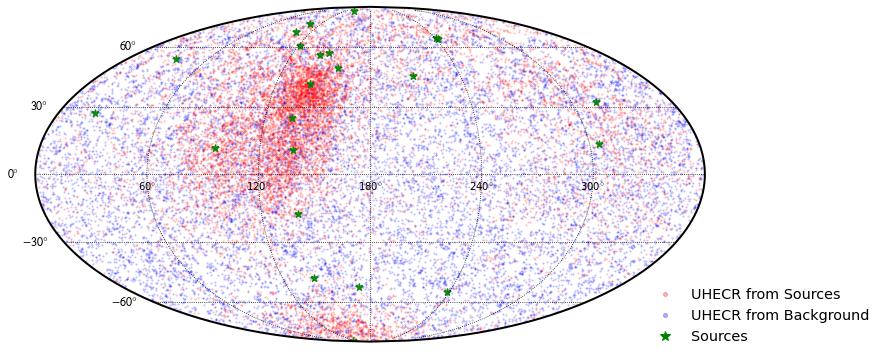

In [ ]:
_, _, lons_earth_src, lats_earth_src = MC_src.getRandomParticles(
            int(N_uhecr * Nrand / 2))

omega_earth_src = SkyCoord(-(np.pi - lons_earth_src) * u.rad,
                     lats_earth_src * u.rad,
                     frame="galactic")

_, _, lons_earth_bg, lats_earth_bg = MC_bg.getRandomParticles(
            int(N_uhecr * Nrand / 2))

omega_earth_bg = SkyCoord(-(np.pi - lons_earth_bg) * u.rad,
                     lats_earth_bg * u.rad,
                     frame="galactic")

coords_src = sim_analysis.data.source.coord

lons_src, lats_src = 180 - coords_src.galactic.l.deg, coords_src.galactic.b.deg

skymap = AllSkyMap(lon_0=180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
skymap.scatter(180 - omega_earth_src.galactic.l.deg,
                omega_earth_src.galactic.b.deg,
                s=4.5,
                color="r",
                alpha=0.25,
                lw=0.,
                label="UHECR from Sources")
skymap.scatter(180 - omega_earth_bg.galactic.l.deg,
                omega_earth_bg.galactic.b.deg,
                s=4.5,
                color="b",
                alpha=0.25,
                lw=0.,
                label="UHECR from Background")
skymap.scatter(lons_src,
                lats_src,
                s=60.0,
                color="g",
                alpha=0.9,
                marker="*",
                label="Sources")

handles = [
    mlines.Line2D([], [],
                    color='r',
                    marker='o',
                    lw=0,
                    markersize=4,
                    alpha=0.3,
                    label="UHECR from Sources"),
    mlines.Line2D([], [],
                    color='b',
                    marker='o',
                    lw=0,
                    markersize=4,
                    alpha=0.3,
                    label="UHECR from Background"),
    mlines.Line2D([], [],
                    color='g',
                    marker='*',
                    lw=0,
                    markersize=10,
                    label="Sources")
]

skymap.legend(handles=handles, bbox_to_anchor=(0.9, 0.2))

skymap.save("GMFplots_resampled_skymap_{0}_{1}.png".format(ptype, tightB_label), dpi=400)

In [ ]:
'''For checks, look at simulation results from UHECRs only from source'''

MC_src = crpropa.ParticleMapsContainer()

# divide energy by Z to get rigidity (to account for composition)
rigidities_gb = np.array(
    [np.float64(energy_gb) / Z for energy_gb in energies_gb])

# add particle to map container
# Coordinate transformation is based on making the final map used for sampling
# to be sampled in the correct coordinates.
for i in src_indices:
    i = int(i)
    for j in range(Nrand):
        c_gal = coords_gb[j][i].galactic
        MC_src.addParticle(pid, rigidities_gb[i],
                                    -(np.pi - c_gal.l.rad), c_gal.b.rad)

# evaluate map used to plot unlensed map using healpy
NPIX = MC_src.getNumberOfPixels(
)  # hardset to 49152 via CRPropa, correleats to ang. res of 0.92 deg
crMap_unlensed_src = np.zeros(NPIX)
rigidities = MC_src.getEnergies(
    int(pid))  # actually getting rigidity
for rigidity in rigidities:
    crMap_unlensed_src += MC_src.getMap(int(pid),
                                            rigidity * crpropa.eV)

import healpy
import matplotlib.cm as cm


# healpy.mollview(map=crMap_unlensed_src, title='UHECR Map at Galactic Boundary', rot=(90, 0, 0), cmap=cm.hot)
ipixs = np.arange(0, 49152, 1, dtype=int)
th, ph = healpy.pix2ang(healpy.npix2nside(49152), ipixs)
lons_crmap, lats_crmap = -np.rad2deg(np.pi - ph), np.rad2deg(np.pi / 2. - th)


# UHECR at earth after lensing

max_count = int(np.max(crMap_unlensed_src))
from scipy.interpolate import griddata
import cartopy.crs as ccrs
# import matplotlib.cm as cm

grid_lons, grid_lats = np.mgrid[-200:200:150j, -90:90:150j]

grid_crMap_unlensed_src = griddata((lons_crmap, lats_crmap), crMap_unlensed_src / max_count, (grid_lons, grid_lats), method="cubic", fill_value=0)

# energy_bins = np.arange(0, int(np.max(map_unlensed))+1, 1)
# uhecr_norm = mcolors.BoundaryNorm(energy_bins, cm.hot_r.N)


skymap = AllSkyMap(figsize=(15,8), lon_0=180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
im = skymap.ax.contourf(grid_lons, grid_lats, grid_crMap_unlensed_src, transform=ccrs.PlateCarree(), cmap=cm.Reds, levels=np.linspace(0, 1, 50), alpha=1)
skymap.ax.set_facecolor('w')
skymap.title("UHECR Map at Galactic Boundary")
cbar = skymap.fig.colorbar(im,  pad=0.1,
                                cmap=im.cmap,
                                orientation='horizontal',
                                alpha=1, shrink=0.65)

# cbar.ax.set_xlim(0, int(np.max(map_unlensed))+1)
# cbar.ax.set_xticks(np.arange(0, int(np.max(map_unlensed))+1, 1))
cbar.set_ticks(np.arange(0, 1.1, 0.1))
cbar.set_ticklabels(["{0:.1f}".format(i) for i in np.arange(0, 1.1, 0.1)])

healpy.mollview(map=crMap_unlensed_src, title='UHECR Map at Galactic Boundary', rot=(0, 0, 0), cmap=cm.hot)

# apply lens of b-field model to get map of uhecrs at earth
# full lens to account for turbulent effects
lens = crpropa.MagneticLens(path_to_lens)
lens.normalizeLens()
MC_src.applyLens(lens)

# same as above, but for lensed version
crMap_lensed_src = np.zeros(NPIX)
rigidities = MC_src.getEnergies(int(pid))
for rigidity in rigidities:
    crMap_lensed_src += MC_src.getMap(int(pid),
                                            rigidity * crpropa.eV)


# healpy.mollview(map=crMap_unlensed, title='UHECR Map at Galactic Boundary', rot=(90, 0, 0), cmap=cm.hot)
ipixs = np.arange(0, 49152, 1, dtype=int)
th, ph = healpy.pix2ang(healpy.npix2nside(49152), ipixs)
lons_crmap, lats_crmap = -np.rad2deg(np.pi - ph), np.rad2deg(np.pi / 2. - th)


# UHECR at earth after lensing

max_count = np.max(crMap_lensed_src)
from scipy.interpolate import griddata
import cartopy.crs as ccrs
# import matplotlib.cm as cm

grid_lons, grid_lats = np.mgrid[-200:200:150j, -90:90:150j]

grid_crMap_lensed_src = griddata((lons_crmap, lats_crmap), crMap_lensed_src / max_count, (grid_lons, grid_lats), method="cubic", fill_value=0)

# energy_bins = np.arange(0, int(np.max(map_unlensed))+1, 1)
# uhecr_norm = mcolors.BoundaryNorm(energy_bins, cm.hot_r.N)


skymap = AllSkyMap(figsize=(15,8), lon_0=180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
im = skymap.ax.contourf(grid_lons, grid_lats, grid_crMap_lensed_src, transform=ccrs.PlateCarree(), cmap=cm.Reds, levels=np.linspace(0, 1, 50), alpha=1)
skymap.ax.set_facecolor('w')
skymap.title("UHECR Map at Earth")
cbar = skymap.fig.colorbar(im,  pad=0.1,
                                cmap=im.cmap,
                                orientation='horizontal',
                                alpha=1, shrink=0.65)

# cbar.ax.set_xlim(0, int(np.max(map_unlensed))+1)
# cbar.ax.set_xticks(np.arange(0, int(np.max(map_unlensed))+1, 1))
cbar.set_ticks(np.arange(0, 1.1, 0.1))
cbar.set_ticklabels(["{0:.1f}".format(i) for i in np.arange(0, 1.1, 0.1)])

healpy.mollview(map=crMap_lensed_src, title='UHECR Map at Earth', rot=(0, 0, 0), cmap=cm.hot)


In [ ]:
'''For checks, using only UHECRs from background'''

MC_bg = crpropa.ParticleMapsContainer()

# divide energy by Z to get rigidity (to account for composition)
rigidities_gb = np.array(
    [np.float64(energy_gb) / Z for energy_gb in energies_gb])

# add particle to map container
# Coordinate transformation is based on making the final map used for sampling
# to be sampled in the correct coordinates.
for i in bg_indices:
    i = int(i)
    for j in range(Nrand):
        c_gal = coords_gb[j][i].galactic
        MC_bg.addParticle(pid, rigidities_gb[i],
                                    -(np.pi - c_gal.l.rad), c_gal.b.rad)

# evaluate map used to plot unlensed map using healpy
NPIX = MC_bg.getNumberOfPixels(
)  # hardset to 49152 via CRPropa, correleats to ang. res of 0.92 deg
crMap_unlensed_bg = np.zeros(NPIX)
rigidities = MC_bg.getEnergies(
    int(pid))  # actually getting rigidity
for rigidity in rigidities:
    crMap_unlensed_bg += MC_bg.getMap(int(pid),
                                            rigidity * crpropa.eV)

'''Doesnt really work due to GEOS shapely error'''
# import healpy
# import matplotlib.cm as cm


# # healpy.mollview(map=crMap_unlensed_bg, title='UHECR Map at Galactic Boundary', rot=(90, 0, 0), cmap=cm.hot)
# ipixs = np.arange(0, 49152, 1, dtype=int)
# th, ph = healpy.pix2ang(healpy.npix2nside(49152), ipixs)
# lons_crmap, lats_crmap = -np.rad2deg(np.pi - ph), np.rad2deg(np.pi / 2. - th)


# # UHECR at earth after lensing

# max_count = int(np.max(crMap_unlensed_bg))
# from scipy.interpolate import griddata
# import cartopy.crs as ccrs
# # import matplotlib.cm as cm

# grid_lons, grid_lats = np.mgrid[-200:200:150j, -90:90:150j]

# grid_crMap_unlensed_bg = griddata((lons_crmap, lats_crmap), crMap_unlensed_bg / max_count, (grid_lons, grid_lats), method="cubic", fill_value=0)

# # energy_bins = np.arange(0, int(np.max(map_unlensed))+1, 1)
# # uhecr_norm = mcolors.BoundaryNorm(energy_bins, cm.hot_r.N)


# skymap = AllSkyMap(figsize=(15,8), lon_0=180)
# skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
# im = skymap.ax.contourf(grid_lons, grid_lats, grid_crMap_unlensed_bg, transform=ccrs.PlateCarree(), cmap=cm.Blues, levels=np.linspace(0, 1, 30), alpha=1)
# skymap.ax.set_facecolor('w')
# skymap.title("UHECR Map at Galactic Boundary")
# cbar = skymap.fig.colorbar(im,  pad=0.1,
#                                 cmap=im.cmap,
#                                 orientation='horizontal',
#                                 alpha=1, shrink=0.65)

# # cbar.ax.set_xlim(0, int(np.max(map_unlensed))+1)
# # cbar.ax.set_xticks(np.arange(0, int(np.max(map_unlensed))+1, 1))
# cbar.set_ticks(np.arange(0, 1.1, 0.1))
# cbar.set_ticklabels(["{0:.1f}".format(i) for i in np.arange(0, 1.1, 0.1)])

healpy.mollview(map=crMap_unlensed_bg, title='UHECR Map at Galactic Boundary', rot=(0, 0, 0), cmap=cm.hot)

# apply lens of b-field model to get map of uhecrs at earth
# full lens to account for turbulent effects
lens = crpropa.MagneticLens(path_to_lens)
lens.normalizeLens()
MC_bg.applyLens(lens)

# same as above, but for lensed version
crMap_lensed_bg = np.zeros(NPIX)
rigidities = MC_bg.getEnergies(int(pid))
for rigidity in rigidities:
    crMap_lensed_bg += MC_bg.getMap(int(pid),
                                            rigidity * crpropa.eV)



import healpy
import matplotlib.cm as cm


# healpy.mollview(map=crMap_unlensed, title='UHECR Map at Galactic Boundary', rot=(90, 0, 0), cmap=cm.hot)
ipixs = np.arange(0, 49152, 1, dtype=int)
th, ph = healpy.pix2ang(healpy.npix2nside(49152), ipixs)
lons_crmap, lats_crmap = -np.rad2deg(np.pi - ph), np.rad2deg(np.pi / 2. - th)


# UHECR at earth after lensing

max_count = np.max(crMap_lensed_bg)
from scipy.interpolate import griddata
import cartopy.crs as ccrs
# import matplotlib.cm as cm

grid_lons, grid_lats = np.mgrid[-200:200:150j, -90:90:150j]

grid_crMap_lensed_bg = griddata((lons_crmap, lats_crmap), crMap_lensed_bg / max_count, (grid_lons, grid_lats), method="cubic", fill_value=0)

# energy_bins = np.arange(0, int(np.max(map_unlensed))+1, 1)
# uhecr_norm = mcolors.BoundaryNorm(energy_bins, cm.hot_r.N)


skymap = AllSkyMap(figsize=(15,8), lon_0=180)
skymap.set_gridlines(color="k", linestyle=":", lw=10, zorder=1)
im = skymap.ax.contourf(grid_lons, grid_lats, grid_crMap_lensed_bg, transform=ccrs.PlateCarree(), cmap=cm.Blues, levels=np.linspace(0, 1, 40), alpha=1)
skymap.ax.set_facecolor('w')
skymap.title("UHECR Map at Earth")
cbar = skymap.fig.colorbar(im,  pad=0.1,
                                cmap=im.cmap,
                                orientation='horizontal',
                                alpha=1, shrink=0.65)

# cbar.ax.set_xlim(0, int(np.max(map_unlensed))+1)
# cbar.ax.set_xticks(np.arange(0, int(np.max(map_unlensed))+1, 1))
cbar.set_ticks(np.arange(0, 1.1, 0.1))
cbar.set_ticklabels(["{0:.1f}".format(i) for i in np.arange(0, 1.1, 0.1)])

healpy.mollview(map=crMap_lensed_bg, title='UHECR Map at Earth', rot=(0, 0, 0), cmap=cm.hot)
